In [1]:
# Source: https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

2022-06-09 21:45:07 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.


In [2]:
# Encode data for the model
training_data = pd.read_csv('./data/training_data.csv')

# Temp df to test function
test_data = training_data[2390:2629]
test_data.columns = test_data.columns.str.lower()
training_data = training_data[0:2390]
training_data.columns = training_data.columns.str.lower()
training_data = training_data.drop(columns=['name', 'last_sale','sales','presale'])
training_data.head(3)
list(training_data.columns)

/var/folders/pr/s8vz2jrj0gzcy0cb3dtmqx800000gn/T/ipykernel_65715/413767461.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  training_data = pd.read_csv('./data/training_data.csv')


['timestamp',
 'token_id',
 'owner',
 'mouth',
 'eyes',
 'hat',
 'fur',
 'background',
 'clothes',
 'earring',
 'eth_fees',
 'eth_sale price',
 'usd_platform_fees',
 'usd_sale_price',
 'index',
 'average_price',
 'max_price',
 'min_price',
 'total_sales',
 'total_volume',
 'unique_buyers',
 'unique_sellers',
 'buyers_ratio',
 'btc_close',
 'btc_volume',
 'eth_close',
 'eth_volume',
 'gas_price',
 'nft',
 'nfts',
 'opensea']

In [3]:
# Test out put -> can be deleted later
training_data_temp = training_data

In [4]:
from sklearn.preprocessing import OneHotEncoder
col_to_encode = training_data[['owner', 'mouth', 'eyes', 'hat', 'fur', 'background', 'clothes', 'earring']]
col_to_encode.fillna('Other', inplace=True)

/var/folders/pr/s8vz2jrj0gzcy0cb3dtmqx800000gn/T/ipykernel_65715/257097117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_to_encode.fillna('Other', inplace=True)


In [5]:
# OneHotEncode data
X = col_to_encode
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(X)
print('done')

done


In [6]:
col_names = ['owner', 'mouth', 'eyes', 'hat', 'fur', 'background', 'clothes', 'earring']
colnames = enc.get_feature_names(col_names)
encoded_traning_data =  pd.DataFrame(enc.fit_transform(X), columns = colnames)
print('done')

done


/Users/jb/opt/anaconda3/envs/DartMachineLearning/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
encoded_traning_data.head(3)

,owner_0xBenj,owner_Brewks,owner_Cryptojtc88,owner_EvanLuthra,owner_Other,owner_coasthawk,owner_zjay,mouth_M1 Bored,mouth_M1 Bored Unshaven,mouth_M1 Bored Unshaven Cigar,...,clothes_M1 Bone Necklace,clothes_M1 Puffy Vest,clothes_M1 Sleeveless Logo T,clothes_M1 Space Suit,clothes_M1 Tanktop,clothes_M1 Wool Turtleneck,clothes_Other,earring_M1 Gold Hoop,earring_M1 Gold Stud,earring_Other
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [8]:
training_data_temp = training_data_temp.drop(columns=col_names)
training_data_dic = training_data_temp.to_dict('list')
encoded_traning_data_dic = encoded_traning_data.to_dict('list')

In [9]:
def merge(d1, d2):
    result = {**d1, **d2}
    return result
encoded_traning_data_temp = merge(encoded_traning_data_dic, training_data_dic)
encoded_traning_data_temp = pd.DataFrame.from_dict(encoded_traning_data_temp)

In [10]:
# get target index no
#list(encoded_traning_data_temp.columns)
index_no = encoded_traning_data_temp.columns.get_loc("eth_sale price")
index_no

61

In [11]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
encoded_traning_data_temp = encoded_traning_data_temp.drop(['timestamp'], 1)
training_set_scaled = sc.fit_transform(encoded_traning_data_temp)
training_set_scaled

/var/folders/pr/s8vz2jrj0gzcy0cb3dtmqx800000gn/T/ipykernel_65715/2405264977.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  encoded_traning_data_temp = encoded_traning_data_temp.drop(['timestamp'], 1)


array([[0.        , 0.        , 0.        , ..., 0.74459459, 0.44607843,
        0.08261636],
       [0.        , 0.        , 0.        , ..., 0.56554054, 0.19117647,
        0.10075671],
       [0.        , 0.        , 0.        , ..., 0.38581081, 0.29411765,
        0.04115269],
       ...,
       [0.        , 0.        , 0.        , ..., 0.55405405, 0.30392157,
        0.52057634],
       [0.        , 0.        , 0.        , ..., 0.83310811, 0.53921569,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.79594595, 0.50490196,
        0.75380947]])

In [12]:
# Delete target column from scaled dataset and create covariates dataset
train_eth_price_scaled = training_set_scaled[:,60]
train_covariates = np.delete(training_set_scaled, np.s_[:60], axis=1)
print('lenght: target ',len(train_eth_price_scaled))
print('lenght: covariates ',len(train_covariates))

lenght: target  2390
lenght: covariates  2390


In [13]:
train_covariates_ts = TimeSeries.from_values(train_covariates)
train_eth_price_scaled_ts = TimeSeries.from_values(train_eth_price_scaled)

In [14]:
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=100,
    random_state=0,
)

In [15]:
model_cov.fit(
    series=[train_eth_price_scaled_ts],
    past_covariates=[train_covariates_ts],
    verbose=True,
)

[2022-06-09 21:45:12,533] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2355 samples.
[2022-06-09 21:45:12,533] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2355 samples.
2022-06-09 21:45:12 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 2355 samples.
[2022-06-09 21:45:12,545] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-09 21:45:12,545] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-09 21:45:12 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-06-09 21:45:12,547] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Light

Training: 0it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

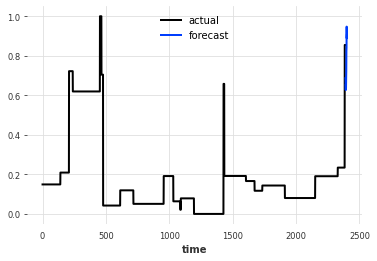

In [26]:
pred_cov = model_cov.predict(n=12, series=train_eth_price_scaled_ts, past_covariates=train_covariates_ts)
train_eth_price_scaled_ts.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()

  0%|          | 0/946 [00:00<?, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

Predicting: 74it [00:00, ?it/s]

MAPE (using covariates) = 9.39%


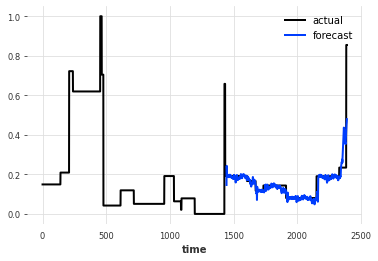

In [28]:
backtest_cov = model_cov.historical_forecasts(
    train_eth_price_scaled_ts,
    past_covariates=train_covariates_ts,
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=True,
)

MAPE (using covariates) = 9.39%


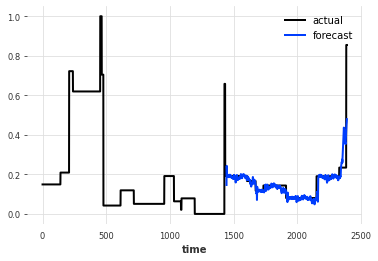

In [29]:
train_eth_price_scaled_ts.plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
print("MAPE (using covariates) = {:.2f}%".format(mape(train_eth_price_scaled_ts, backtest_cov)))

In [16]:
#model = keras.Sequential()
#model.add(layers.GRU(64, input_shape=(5, 5040)))
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(10))
#print(model.summary())